<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter11/conv_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
%pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [106]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = ConvAutoEncoder().to(device)
%pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(2,1,28,28));


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [107]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

In [108]:
@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [109]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

Epoch 1/5 Progress: 20.00% 
Epoch 1 - Avg Train Loss: 0.1867, Avg Val Loss: 0.1023
Epoch 2/5 Progress: 40.00% 
Epoch 2 - Avg Train Loss: 0.1384, Avg Val Loss: 0.0901
Epoch 3/5 Progress: 60.00% 
Epoch 3 - Avg Train Loss: 0.1172, Avg Val Loss: 0.0829
Epoch 4/5 Progress: 80.00% 
Epoch 4 - Avg Train Loss: 0.1048, Avg Val Loss: 0.0779
Epoch 5/5 Progress: 100.00% 
Epoch 5 - Avg Train Loss: 0.0964, Avg Val Loss: 0.0741


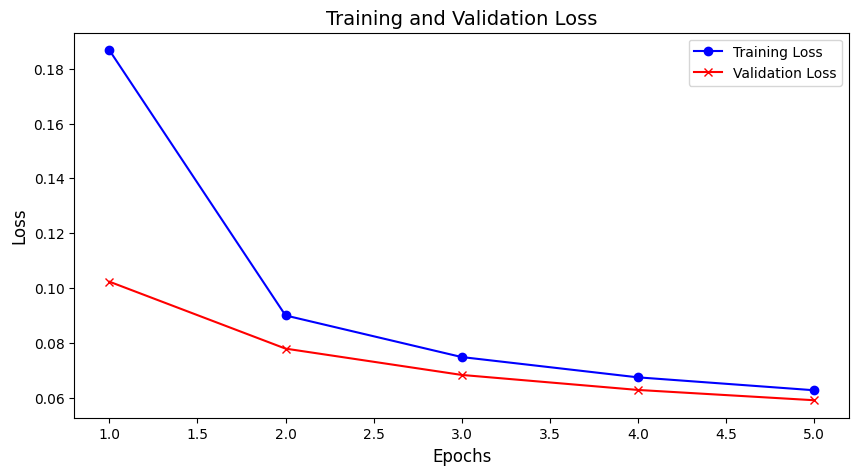

In [110]:
import matplotlib.pyplot as plt

class Report:
    def __init__(self, num_epochs):
        self.num_epochs = num_epochs
        self.history = {'epoch': [], 'trn_loss': [], 'val_loss': []}

    def record(self, epoch, trn_loss=None, val_loss=None):
        # Ensure we're only appending one loss per epoch
        if trn_loss is not None:
            self.history['trn_loss'].append(trn_loss.cpu().detach().numpy())  # Move to CPU and convert to NumPy
        if val_loss is not None:
            self.history['val_loss'].append(val_loss.cpu().detach().numpy())  # Same here

        print(f"Epoch {epoch}/{self.num_epochs} Progress: {epoch/self.num_epochs*100:.2f}%", end=' ')


    def report_avgs(self, epoch):
        avg_trn_loss = sum(self.history['trn_loss']) / len(self.history['trn_loss'])
        avg_val_loss = sum(self.history['val_loss']) / len(self.history['val_loss'])
        print(f"\nEpoch {epoch} - Avg Train Loss: {avg_trn_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

    # Add plot_epochs method for plotting
    def plot_epochs(self, log=False):
        # Ensure the lengths of the data match the number of epochs
        epochs = list(range(1, self.num_epochs + 1))

        # If there’s a mismatch in lengths, raise an error
        if len(self.history['trn_loss']) != self.num_epochs:
            raise ValueError(f"Mismatch in lengths: {len(self.history['trn_loss'])} (train) vs {self.num_epochs} (epochs)")
        if len(self.history['val_loss']) != self.num_epochs:
            raise ValueError(f"Mismatch in lengths: {len(self.history['val_loss'])} (val) vs {self.num_epochs} (epochs)")

        plt.figure(figsize=(10, 5))

        # Plot training loss
        plt.plot(epochs, self.history['trn_loss'], label='Training Loss', color='blue', marker='o')

        # Plot validation loss
        plt.plot(epochs, self.history['val_loss'], label='Validation Loss', color='red', marker='x')

        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Training and Validation Loss', fontsize=14)
        plt.legend()

        # If log=True, save the plot
        if log:
            plt.savefig('loss_plot.png')

        plt.show()


num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    # Training loop
    trn_losses = []
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        trn_losses.append(loss)
    avg_trn_loss = sum(trn_losses) / len(trn_losses)

    # Validation loop
    val_losses = []
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        val_losses.append(loss)
    avg_val_loss = sum(val_losses) / len(val_losses)

    # Record the average losses
    log.record(epoch + 1, trn_loss=avg_trn_loss, val_loss=avg_val_loss)
    log.report_avgs(epoch + 1)

log.plot_epochs()


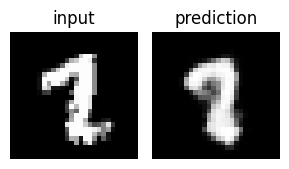

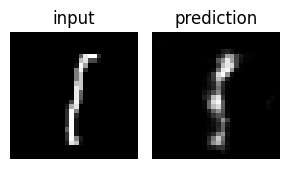

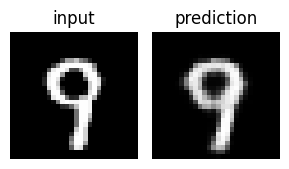

In [111]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

In [112]:
latent_vectors = []
classes = []

In [113]:
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)

In [114]:
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

In [115]:
from sklearn.manifold import TSNE
tsne = TSNE(2)

In [116]:
clustered = tsne.fit_transform(latent_vectors)

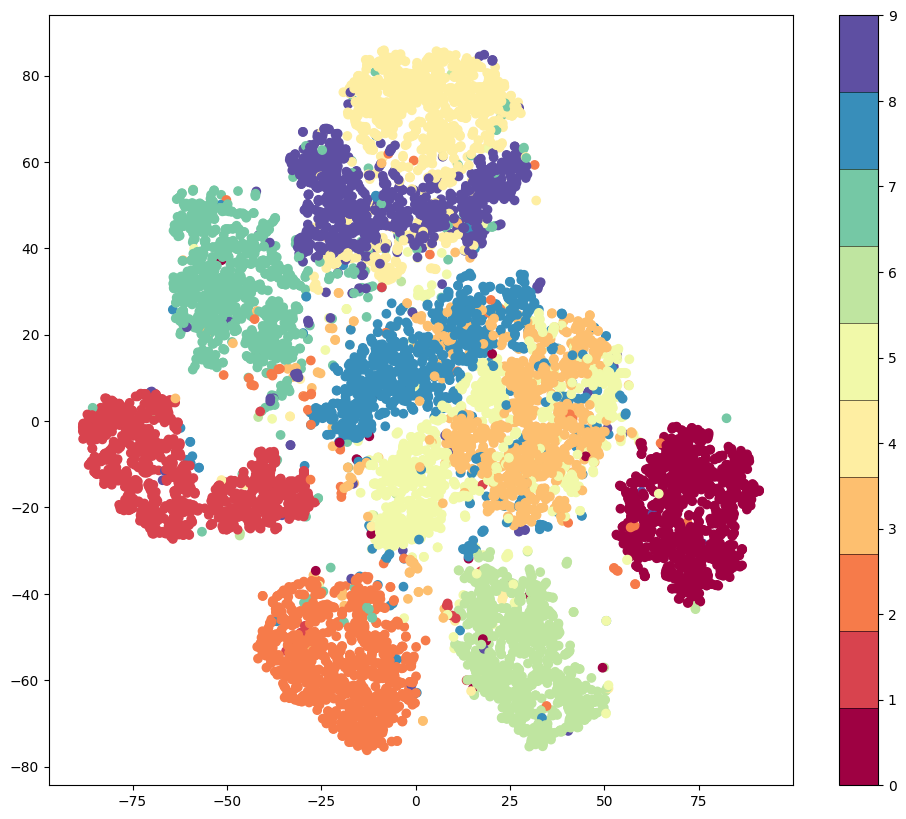

In [117]:
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

In [118]:
latent_vectors = []
classes = []
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im))
    classes.extend(clss)
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy().reshape(10000, -1)

In [119]:
rand_vectors = []
for col in latent_vectors.transpose(1,0):
    mu, sigma = col.mean(), col.std()
    rand_vectors.append(sigma*torch.randn(1,100) + mu)

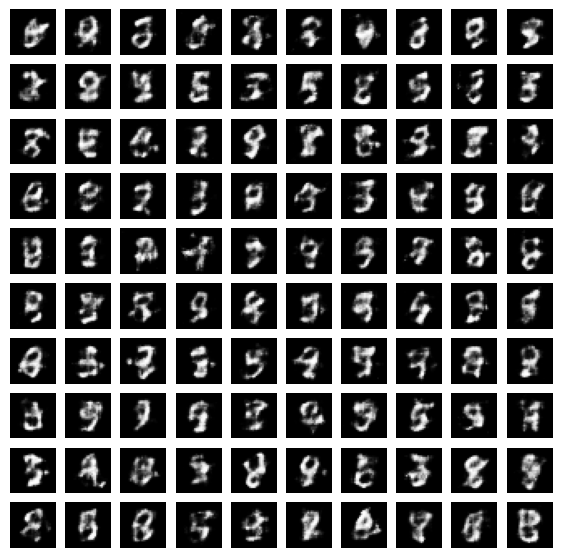

In [120]:
rand_vectors = torch.cat(rand_vectors).transpose(1,0).to(device)
fig, ax = plt.subplots(10,10,figsize=(7,7)); ax = iter(ax.flat)
for p in rand_vectors:
    img = model.decoder(p.reshape(1,64,2,2)).view(28,28)
    show(img, ax=next(ax))